# Modeling and Evaluation

In this step, the cleaned dataset is used to train and evaluate several models. These are evaluated in terms of their Area Under the Receiver Operating Characteristic Curve (AUC-ROC) score and cross-entropy loss score. Furthermore, two feature engineering methods are used and evaluated. These methods are:
- **Baseline**: Features are only modified via z-normalisation and one-hot encoding.
- **Difference**: In addition to the baseline, we take the difference between red/blue columns, effectively reducing almost half of the features.
  
The dataset is split in a 80/20 training/testing sets. 

Based on this [competetive ML survey](https://mlcontests.com/state-of-competitive-machine-learning-2022/#tabular-data), it is discussed that gradient-boosted tree-based models are effective for tabular data. Therefore, the selection of hypothesis classes includes the `XGBoost` class of models. In addition, for more variation in the inductive bias, the `RandomForest`, `SVM`, and `MLP` models were included. The list of models to be evaluated is the following:
- [XGBoost](https://github.com/dmlc/xgboost) classifier
- Random Forest classifier
- Support Vector Machine 
- Multi-Layer Perceptron

To optimise the hyperparameters of the models, we opt for Bayesian search methods, as the hyperparameters of the selected hypothesis classes have a high dimensionality. The Tree-structured Parzen Estimator (TPE) method is utilised, where, for each feature engineered dataset (baseline/difference), each model is tuned with 100 trials. During this process, the training set is folded via `kfold` cross-validation with $k = 5$, to produce validation sets, and the scoring function is the AUC score that we try to maximize. 

## 0. Install libraries and define helper functions

To tune the hyperparameters, the `optuna` library is used, which offers the `TPESampler` (Tree-structured Parzen Estimator) as a Bayesian optimisation algorithm. Furthermore, the `xgboost` library is used, which offers the XGBoost classification model. 

In [1]:
!pip install xgboost optuna

  Using cached xgboost-2.0.3-py3-none-win_amd64.whl (99.8 MB)
  Using cached optuna-3.5.0-py3-none-any.whl (413 kB)
  Using cached alembic-1.13.1-py3-none-any.whl (233 kB)
  Using cached Mako-1.3.0-py3-none-any.whl (78 kB)


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

pd.set_option('display.max_columns', None)

Below are some helper functions to serialize and deserialize study objects and models.

In [2]:
# !install joblib
import joblib
import pickle

def save_study(path, study):
    joblib.dump(study, path)

def load_study(path):
    jl = joblib.load(path)
    return jl

def save_model(model, path):
    
    with open(path, 'wb') as f:
        pickle.dump(model, f)

def load_model(path):

    with open(path, 'rb') as f:
        model = pickle.load(f)
    return model

To evaluate with repeated runs over different dataset splits, the following function is defined.

In [3]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, log_loss

def evaluate_n_repeated(X, y, models: dict, N):
    random_states = range(N)
    auc_scores = defaultdict(list)
    logl_scores = defaultdict(list)

    for name, model in models.items():
        for rs in random_states:

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=rs)
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            auc = roc_auc_score(y_test, y_pred)
            logl = log_loss(y_test, y_pred)
            auc_scores[name].append(auc)
            logl_scores[name].append(logl)

        print(f"{name}: mean auc {sum(auc_scores[name])/N}, mean log loss {sum(logl_scores[name])/N}")
    
    auc_scores = pd.DataFrame(auc_scores)
    logl_scores = pd.DataFrame(logl_scores)
    
    return auc_scores, logl_scores

## 1. Hyperparameter Objective functions

For each hypothesis class, an objective function is defined that the TPE optimizer tries to maximize with respect to the AUC score. The search space is deliberately made very large, so that as much of the space can be explored, and in the later iterations, as much of the space can be exploited and narrowed down to find the best parameters.

In [69]:
from optuna.trial import Trial

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

def objective_RF(trial: Trial, X_train, y_train):

    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000, step=50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 50, step=5),
        'max_depth': trial.suggest_int('max_depth', 4, 24),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.1, 0.3, 0.5, 0.7, 0.9]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False])
    }

    clf = RandomForestClassifier(n_jobs=-1, **param_grid)

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='roc_auc')
    auc = score.mean()
    return auc

def objective_XGBoost(trial: Trial, X_train, y_train):

    param_grid = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 5000, step=50),
        'max_depth': trial.suggest_int('max_depth', 4, 24),
        'eta': trial.suggest_float('eta', 0.0, 1.0),
        'gamma': trial.suggest_float('gamma', 0.0, 100.0),
        'reg_alpha' : trial.suggest_float('reg_alpha', 0.0, 100.0),
        'reg_lambda' : trial.suggest_float('reg_lambda', 0.0, 100.0),
        'subsample': trial.suggest_float('subsample', 0.0, 1.0)
    }

    clf = XGBClassifier(n_jobs=-1, objective='binary:logistic', **param_grid)

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='roc_auc')
    auc = score.mean()
    return auc

def objective_SVM(trial: Trial, X_train, y_train):

    param_grid = {
        'C': trial.suggest_float('C', 0.0001, 1000, log=True),
        'kernel': trial.suggest_categorical('kernel', ['rbf', 'poly']),
        'degree': trial.suggest_categorical('degree', [3, 5, 7, 9, 12]),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto', 0.5, 1.5, 2.5]),
        'shrinking': trial.suggest_categorical('shrinking', [True, False]),
    }

    clf = SVC(max_iter=1000, **param_grid)

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='roc_auc')
    auc = score.mean()
    return auc

def objective_MLP(trial: Trial, X_train, y_train):

    num_hiddenlayers = trial.suggest_int('num_hiddenlayers', 2, 10)

    hidden_layer_sizes = [trial.suggest_int(f'layer_size_{n}', 10, 200, step=5) for n in range(num_hiddenlayers)]

    param_grid = {
        'hidden_layer_sizes': hidden_layer_sizes,
        'activation': trial.suggest_categorical('activation', ['relu', 'tanh', 'logistic']),
        'learning_rate': trial.suggest_categorical('learning_rate', ['constant', 'invscaling', 'adaptive']),
        'solver': trial.suggest_categorical('solver', ['lbfgs', 'sgd', 'adam']),
        'batch_size': trial.suggest_categorical('batch_size', ['auto', 32, 64, 128]),
        'alpha': trial.suggest_float('alpha', 0.0, 100.0),
        'learning_rate_init': trial.suggest_float('learning_rate_init', 0.00001, 2.0, log=True)
    }

    clf = MLPClassifier(max_iter=1000, early_stopping=True, **param_grid)

    score = cross_val_score(clf, X_train, y_train, n_jobs=-1, cv=5, scoring='roc_auc')
    auc = score.mean()
    return auc

## 2. Baseline dataset

We use the baseline dataset by normalising the numeric features to have mean 0 and unit variance, and one-hot encoding the catergorical features.

In [241]:
df = pd.read_csv('../datasets/data_cleaned.csv')

fighter_names = df[['R_fighter', 'B_fighter']]
df = df.drop(columns=['R_fighter', 'B_fighter'])

# one-hot encode categoricals
df_dummies = pd.get_dummies(df.select_dtypes(exclude='number'))
df_num = df.select_dtypes(include='number')

df_y = df_num['Winner']
df_num = df_num.drop(columns=['Winner'])

# z-normalisation
df_num = (df_num - df_num.mean()) / df_num.std()

df_X = pd.concat([df_num, df_dummies], axis=1)

df_X

,R_age,R_Weight_lbs,R_Reach_cms,R_Height_cms,B_age,B_Weight_lbs,B_Reach_cms,B_Height_cms,B_avg_KD,B_avg_opp_KD,B_avg_SIG_STR_pct,B_avg_opp_SIG_STR_pct,B_avg_TD_pct,B_avg_opp_TD_pct,B_avg_SUB_ATT,B_avg_opp_SUB_ATT,B_avg_REV,B_avg_opp_REV,B_avg_SIG_STR_att,B_avg_SIG_STR_landed,B_avg_opp_SIG_STR_att,B_avg_opp_SIG_STR_landed,B_avg_TOTAL_STR_att,B_avg_TOTAL_STR_landed,B_avg_opp_TOTAL_STR_att,B_avg_opp_TOTAL_STR_landed,B_avg_TD_att,B_avg_TD_landed,B_avg_opp_TD_att,B_avg_opp_TD_landed,B_avg_HEAD_att,B_avg_HEAD_landed,B_avg_opp_HEAD_att,B_avg_opp_HEAD_landed,B_avg_BODY_att,B_avg_BODY_landed,B_avg_opp_BODY_att,B_avg_opp_BODY_landed,B_avg_LEG_att,B_avg_LEG_landed,B_avg_opp_LEG_att,B_avg_opp_LEG_landed,B_avg_DISTANCE_att,B_avg_DISTANCE_landed,B_avg_opp_DISTANCE_att,B_avg_opp_DISTANCE_landed,B_avg_CLINCH_att,B_avg_CLINCH_landed,B_avg_opp_CLINCH_att,B_avg_opp_CLINCH_landed,B_avg_GROUND_att,B_avg_GROUND_landed,B_avg_opp_GROUND_att,B_avg_opp_GROUND_landed,B_avg_CTRL_time(seconds),B_avg_opp_CTRL_time(seconds),B_total_time_fought(seconds),B_total_rounds_fought,B_total_title_bouts,B_current_win_streak,B_current_lose_streak,B_longest_win_streak,B_wins,B_losses,B_win_by_Decision_Majority,B_win_by_Decision_Split,B_win_by_Decision_Unanimous,B_win_by_KO/TKO,B_win_by_Submission,B_win_by_TKO_Doctor_Stoppage,R_avg_KD,R_avg_opp_KD,R_avg_SIG_STR_pct,R_avg_opp_SIG_STR_pct,R_avg_TD_pct,R_avg_opp_TD_pct,R_avg_SUB_ATT,R_avg_opp_SUB_ATT,R_avg_REV,R_avg_opp_REV,R_avg_SIG_STR_att,R_avg_SIG_STR_landed,R_avg_opp_SIG_STR_att,R_avg_opp_SIG_STR_landed,R_avg_TOTAL_STR_att,R_avg_TOTAL_STR_landed,R_avg_opp_TOTAL_STR_att,R_avg_opp_TOTAL_STR_landed,R_avg_TD_att,R_avg_TD_landed,R_avg_opp_TD_att,R_avg_opp_TD_landed,R_avg_HEAD_att,R_avg_HEAD_landed,R_avg_opp_HEAD_att,R_avg_opp_HEAD_landed,R_avg_BODY_att,R_avg_BODY_landed,R_avg_opp_BODY_att,R_avg_opp_BODY_landed,R_avg_LEG_att,R_avg_LEG_landed,R_avg_opp_LEG_att,R_avg_opp_LEG_landed,R_avg_DISTANCE_att,R_avg_DISTANCE_landed,R_avg_opp_DISTANCE_att,R_avg_opp_DISTANCE_landed,R_avg_CLINCH_att,R_avg_CLINCH_landed,R_avg_opp_CLINCH_att,R_avg_opp_CLINCH_landed,R_avg_GROUND_att,R_avg_GROUND_landed,R_avg_opp_GROUND_att,R_avg_opp_GROUND_landed,R_avg_CTRL_time(seconds),R_avg_opp_CTRL_time(seconds),R_total_time_fought(seconds),R_total_rounds_fought,R_total_title_bouts,R_current_win_streak,R_current_lose_streak,R_longest_win_streak,R_wins,R_losses,R_win_by_Decision_Majority,R_win_by_Decision_Split,R_win_by_Decision_Unanimous,R_win_by_KO/TKO,R_win_by_Submission,R_win_by_TKO_Doctor_Stoppage,title_bout,location_Argentina,location_Australia,location_Brazil,location_Canada,location_Chile,location_China,location_Croatia,location_Czech Republic,location_Denmark,location_France,location_Germany,location_Ireland,location_Japan,location_Mexico,location_Netherlands,location_New Zealand,location_Philippines,location_Poland,location_Russia,location_Singapore,location_South Korea,location_Sweden,location_USA,location_United Arab Emirates,location_United Kingdom,location_Uruguay,weight_class_Bantamweight,weight_class_CatchWeight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_LightHeavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Welterweight,weight_class_WomenBantamweight,weight_class_WomenFeatherweight,weight_class_WomenFlyweight,weight_class_WomenStrawweight,B_Stance_Open Stance,B_Stance_Orthodox,B_Stance_Southpaw,B_Stance_Switch,R_Stance_Open Stance,R_Stance_Orthodox,R_Stance_Southpaw,R_Stance_Switch
0,1.137147,1.165380,0.954343,1.666617,0.836032,1.204234,1.002422,0.835070,1.667639,-0.524098,0.443060,-0.041985,-1.023120,-0.964579,-0.612826,-0.588072,-0.441607,-0.420704,0.140854,-0.020842,0.121087,0.218918,-0.203823,-0.536965,-0.157964,-0.261383,-0.916680,-0.815537,-0.568251,-0.811311,0.181512,-0.083247,0.077955,0.048846,-0.122151,-0.024594,0.112351,0.317727,0.101181,0.175768,0.288272,0.401999,0.308632,0.237463,0.353173,0.626836,-0.418742,-0.353513,-0.625491,-0.595384,-0.544403,-0.573022,

### 2.1. Hyperparameter Optimisation


In [56]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.2, stratify=df_y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4812, 180), (1204, 180), (4812,), (1204,))

The TPE optimisation is run for 100 trials to obtain a good estimate of the hyperparameters.

In [ ]:
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

objectives = [
    ('random_forest', objective_RF), 
    ('xgboost', objective_XGBoost), 
    ('svm', objective_SVM), 
    ('mlp', objective_MLP)
]

N_TRIALS = 100

studies = {}

for name, obj in objectives:
    study = create_study(direction="maximize", sampler=TPESampler(), pruner=HyperbandPruner())
    study.optimize(lambda trial: obj(trial, X_train, y_train), n_trials=N_TRIALS, n_jobs=-1, show_progress_bar=True, gc_after_trial=True)
    study.trials_dataframe().to_csv(f"../hypopt/trials/tpe_baseline_{name}.csv", index=False)
    studies[name] = study

Save the studies for future analysis

In [17]:
for name, st in studies.items():
    save_study(f'../hypopt/studies/baseline_study_{name}.pkl', st)

### 2.2. TPE Analysis

Let us analyse the optimisation studies.

In [245]:
from optuna.visualization import plot_optimization_history, plot_param_importances

names = ['random_forest', 'xgboost', 'svm', 'mlp']

studies = {}
for name in names:
    studies[name] = load_study(f'../hypopt/studies/baseline_study_{name}.pkl')

Starting with the optimisation history, we can plot the timeline for each model

In [6]:
for i, (name, st) in enumerate(studies.items()):
    f = plot_optimization_history(st, error_bar=True)
    f.update_layout(title=f'Optimisation history {name}')
    f.show()

Another important aspect is the parameter importance of each model, which we can also show.

In [7]:
for i, (name, st) in enumerate(studies.items()):
    f = plot_param_importances(st)
    f.update_layout(title=f'Hyperparameter importances {name}')
    f.show()

Notice how many of the parameters of the MLP model influence the search, whereas for other models only a few parameters influence the search. 

### 2.3. Significance testing

Using the hyperparameters from the conducted optimisation studies, we can construct the "best" models. These are then used to sample `N` repeated stratified AUC and log loss scores, where `N` is determined via power analysis.  

In [250]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# construct dictionary of best params
optimal_params = {name: st.best_params for name, st in studies.items()}
optimal_params['mlp']['hidden_layer_sizes'] = [optimal_params['mlp']['layer_size_0'], optimal_params['mlp']['layer_size_1']]
del optimal_params['mlp']['layer_size_0']
del optimal_params['mlp']['layer_size_1']
del optimal_params['mlp']['num_hiddenlayers']

model_templates = [
    RandomForestClassifier(n_jobs=-1),
    XGBClassifier(n_jobs=-1, objective='binary:logistic'),
    SVC(max_iter=1000, probability=True),
    MLPClassifier(max_iter=1000, early_stopping=True)
]

models = {name: model.set_params(**params) for (name, params), model in zip(optimal_params.items(), model_templates)}

models

{'random_forest': RandomForestClassifier(bootstrap=False, criterion='entropy', max_depth=10,
                        max_features=0.3, min_samples_leaf=10, n_estimators=1500,
                        n_jobs=-1),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.8384322876754022,
               eval_metric=None, feature_types=None, gamma=2.862111112171506,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=17, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=3300, n_jobs=-1,
               num_paral

For each pair of models, we perform one-sided t-tests to determine whether the mean score of one model is significantly greater than the mean score of another model. Since we perform several tests for each pair, the risk of a type-I error increases, which means we need to apply the Bonferonni correction to the significance level. 

$\alpha = 0.05/k$, where k is the number of pairs that we test. In this case, 12 pairs.

In [407]:
import statsmodels.stats.power as smp

power_analysis = smp.TTestIndPower()
n_repeated = int(power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05/12, alternative='larger'))
n_repeated

invalid value encountered in _nct_sf


98

After collection of the samples, we save them for later use.

In [49]:
df_auc, df_logl = evaluate_n_repeated(df_X, df_y, models, n_repeated)

df_auc.to_csv("../score_samples/baseline_auc.csv", index=False)
df_logl.to_csv("../score_samples/baseline_logl.csv", index=False)

display(df_auc, df_logl)

random_forest: mean auc 0.6029822206478183, mean log loss 12.323676970338903
xgboost: mean auc 0.615188349766871, mean log loss 12.528156194072302
svm: mean auc 0.5601799998029211, mean log loss 15.22197797431415
mlp: mean auc 0.6218968138528399, mean log loss 12.109676483623964


,random_forest,xgboost,svm,mlp
0,0.604961,0.635279,0.572103,0.633248
1,0.599684,0.610798,0.577576,0.608917
2,0.604559,0.608802,0.551685,0.620033
3,0.607794,0.614183,0.564292,0.625964
4,0.588144,0.614802,0.544491,0.617992
...,...,...,...,...
80,0.599558,0.617888,0.542714,0.625127
81,0.588017,0.583565,0.558590,0.608631
82,0.595428,0.595966,0.555424,0.602608
83,0.588866,0.606095,0.560976,0.623704


,random_forest,xgboost,svm,mlp
0,12.220744,11.819083,15.003269,11.704347
1,12.364181,12.737061,14.400870,12.651010
2,12.364170,12.794436,15.433592,12.306764
3,12.048627,12.450203,14.659067,11.847789
4,12.737113,12.679682,16.035995,12.134658
...,...,...,...,...
80,12.450237,12.335454,15.749148,11.962532
81,12.823169,13.511620,15.548316,12.651011
82,12.593671,13.138686,15.490953,12.651025
83,12.765797,12.880497,15.290145,12.019905


To report on the scores, we need the mean and standard deviation.

In [131]:
df_auc = pd.read_csv('../score_samples/baseline_auc.csv')
df_logl = pd.read_csv('../score_samples/baseline_logl.csv')

display(df_auc.agg(['mean', 'std']), df_logl.agg(['mean', 'std']))

,random_forest,xgboost,svm,mlp
mean,0.602982,0.615188,0.560180,0.621897
std,0.009396,0.013475,0.014682,0.012060


,random_forest,xgboost,svm,mlp
mean,12.323677,12.528156,15.221978,12.109676
std,0.307324,0.448839,0.584206,0.400244


Plotting these values shows where the sample mean lies.

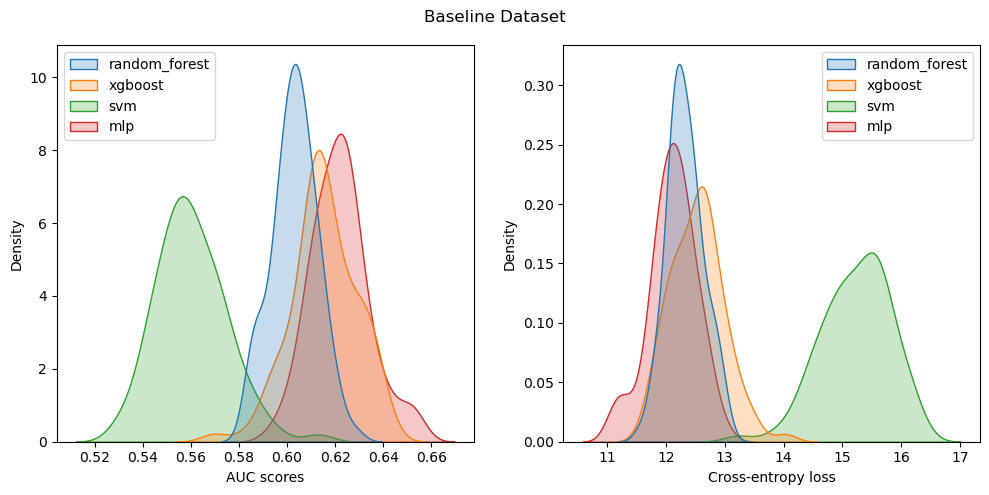

In [134]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Baseline Dataset")
sns.kdeplot(df_auc, fill=True, ax=ax1)
sns.move_legend(ax1, "upper left")
ax1.set_xlabel('AUC scores')

sns.kdeplot(df_logl, fill=True, ax=ax2)
sns.move_legend(ax2, "upper right")
ax2.set_xlabel('Cross-entropy loss')

plt.tight_layout()

For all combinations of model pairs, one-sided t-tests are performed

In [95]:
from scipy.stats import ttest_ind

all_pairs = [(a, b) for a in list(models.keys()) for b in set(models.keys()) - set([a])] 

auc_stats = {}
logl_stats = {}

for m1, m2 in all_pairs:
    t_val, p_val = ttest_ind(df_auc[m1], df_auc[m2], equal_var=False, alternative='greater')
    auc_stats[f"{m1} > {m2}"] = [t_val, p_val]

    t_val, p_val = ttest_ind(df_logl[m1], df_logl[m2], equal_var=False, alternative='greater')
    logl_stats[f"{m1} > {m2}"] = [t_val, p_val]

auc_stats = pd.DataFrame(auc_stats, index=['t_stat', 'p_val']).T
logl_stats = pd.DataFrame(logl_stats, index=['t_stat', 'p_val']).T

In [97]:
alpha = 0.05/12
auc_stats['reject H0?'] = auc_stats['p_val'] < alpha
logl_stats['reject H0?'] = logl_stats['p_val'] < alpha

display(auc_stats, logl_stats), f"Bonferonni correction alpha = {alpha}"

,t_stat,p_val,reject H0?
random_forest > mlp,-11.406238,1.000000e+00,False
random_forest > xgboost,-6.850202,1.000000e+00,False
random_forest > svm,22.638112,2.039853e-49,True
xgboost > random_forest,6.850202,8.883976e-11,True
xgboost > mlp,-3.420094,9.996060e-01,False
xgboost > svm,25.448349,1.283303e-59,True
svm > random_forest,-22.638112,1.000000e+00,False
svm > mlp,-29.946957,1.000000e+00,False
svm > xgboost,-25.448349,1.000000e+00,False
mlp > random_forest,11.406238,1.103614e-22,True


,t_stat,p_val,reject H0?
random_forest > mlp,3.909828,6.847019e-05,True
random_forest > xgboost,-3.465632,9.996541e-01,False
random_forest > svm,-40.479662,1.000000e+00,False
xgboost > random_forest,3.465632,3.458805e-04,True
xgboost > mlp,6.415614,7.041061e-10,True
xgboost > svm,-33.711423,1.000000e+00,False
svm > random_forest,40.479662,8.119473e-75,True
svm > mlp,40.519033,1.634246e-82,True
svm > xgboost,33.711423,3.092001e-74,True
mlp > random_forest,-3.909828,9.999315e-01,False


(None, 'Bonferonni correction alpha = 0.004166666666666667')

We can see that it is statistically significant that the mean AUC of MLP is greater than the mean AUC of other models. 

### 2.4. Evaluation plots

In [251]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.2, stratify=df_y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4812, 180), (1204, 180), (4812,), (1204,))

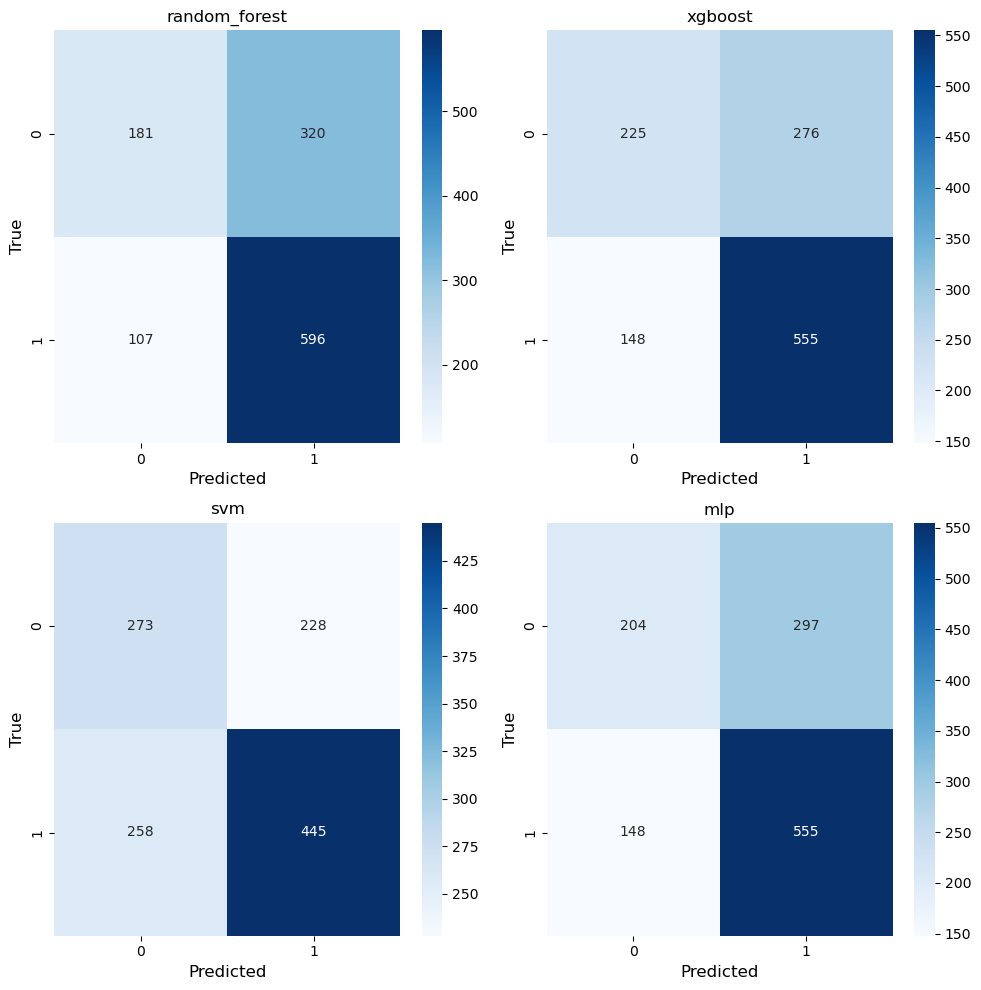

In [252]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, (name, clf) in zip(axes, models.items()):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'{name}', fontsize=12)

plt.tight_layout()
plt.show()

The confusion matrices imply that all models struggle with both false positive and false negative errors.

### 2.5. Feature Importance

In [284]:
import shap

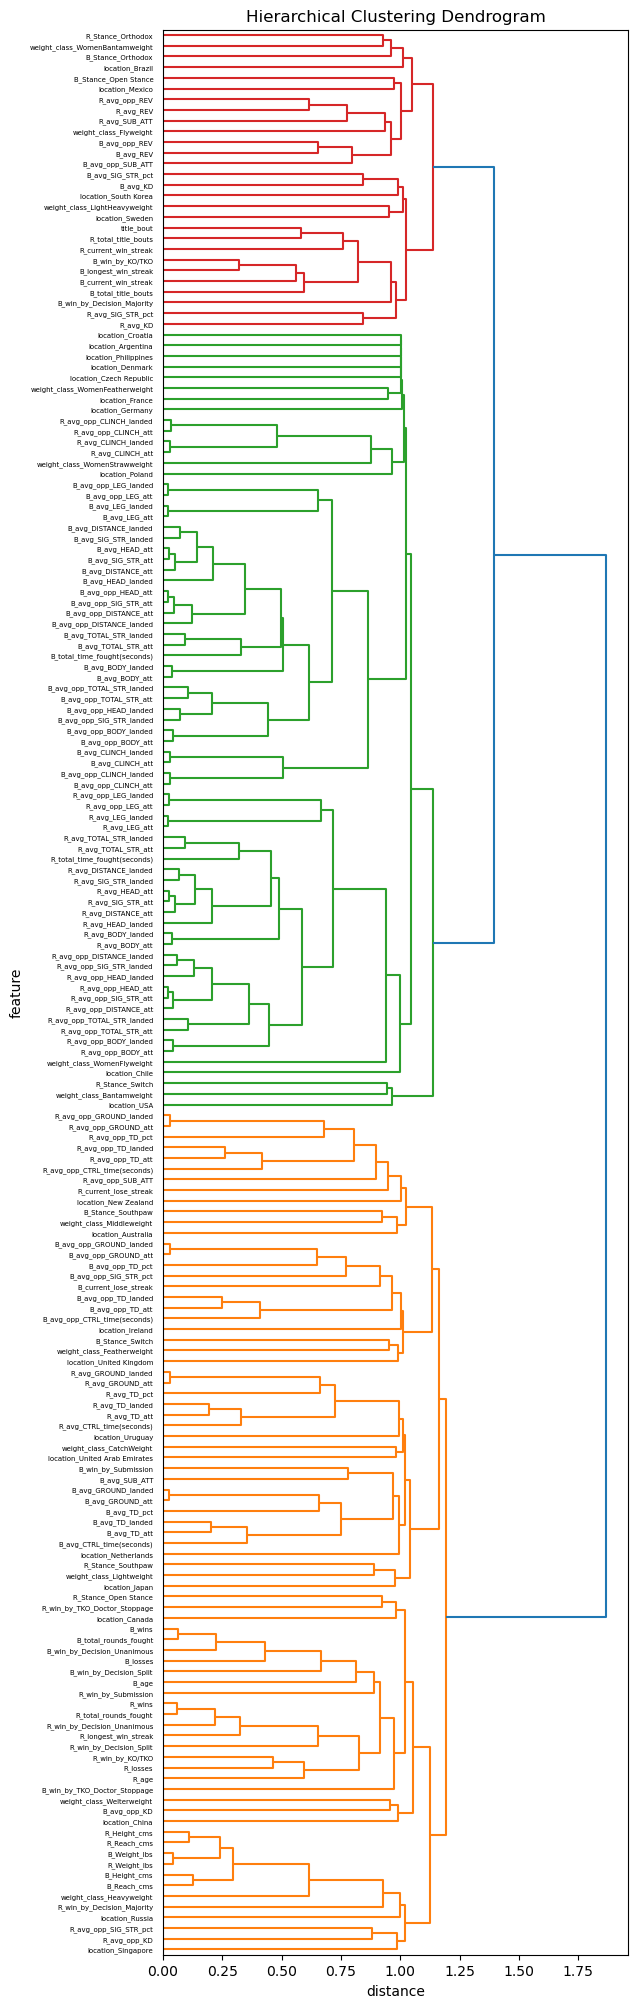

In [287]:
from scipy.cluster import hierarchy

partition_tree = shap.utils.partition_tree(X_train)
plt.figure(figsize=(6, 25))
hierarchy.dendrogram(partition_tree, labels=X_train.columns, orientation='right')

plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("feature")
plt.xlabel("distance")
plt.show()

In [392]:
shap.initjs()

# shap does not accept boolean features because these are seen as categorical
X_train['title_bout'] = X_train['title_bout']*1
X_test['title_bout'] = X_test['title_bout']*1

shap_values = {}

mlp_model = models['mlp']

explainer = shap.PermutationExplainer(mlp_model.predict_proba, X_train, feature_names=X_train.columns)
mlp_shap_values = explainer(X_test)[..., 1]

Permutation explainer: 1205it [07:49,  2.51it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


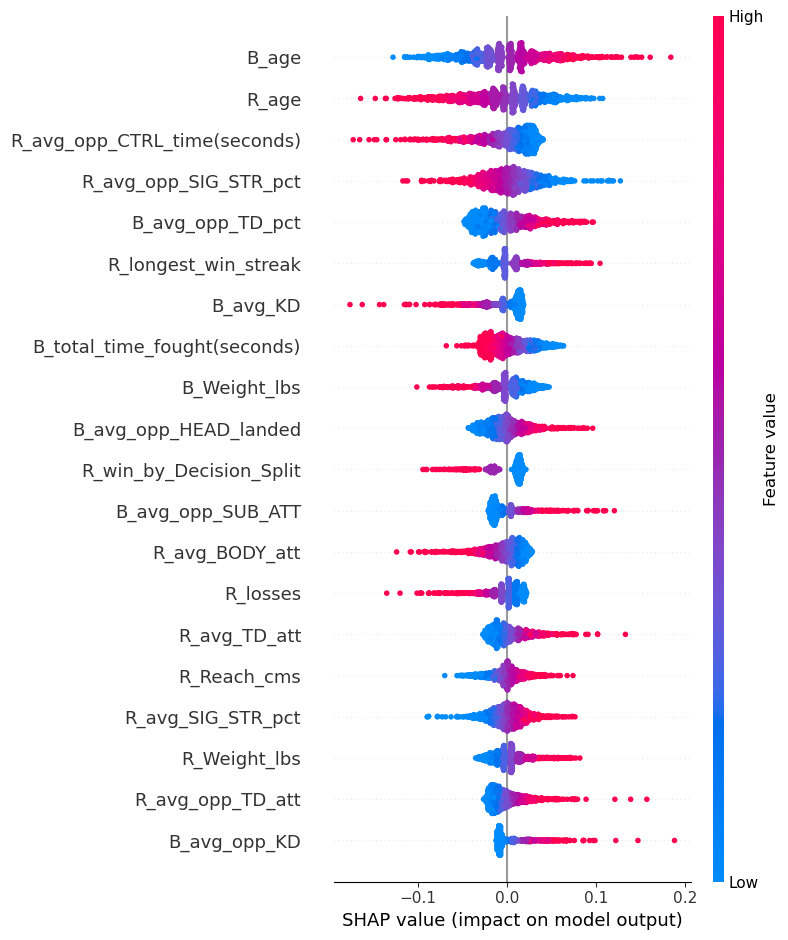

In [393]:
shap.summary_plot(mlp_shap_values)

## 3. Difference dataset

In the difference dataset, the columns that contain `B_` are subtracted from the columns that contain `R_`, to obtain a new reduced feature set.  

In [394]:
df = pd.read_csv('../datasets/data_cleaned.csv')

fighter_names = df[['R_fighter', 'B_fighter']]
df = df.drop(columns=['R_fighter', 'B_fighter'])

# one-hot encode categoricals
df_dummies = pd.get_dummies(df.select_dtypes(exclude='number'))
df_num = df.select_dtypes(include='number')

# categoricals with R_ or B_ prefix
cat_red_dummies = df_dummies.filter(regex='^R_.*')
cat_blue_dummies = df_dummies.filter(regex='^B_.*')

# difference between R_ and B_ columns
cat_diff = pd.DataFrame(
    cat_red_dummies.values.astype('float') - cat_blue_dummies.values.astype('float'),
    columns=[f"diff_{c[2:]}" for c in cat_red_dummies.columns]
)

# list of columns to drop
cat_drop = list(df_dummies.filter(regex='^(R_|B_).*'))
df_dummies = df_dummies[df_dummies.columns.drop(cat_drop)] 

df_y = df_num['Winner']
df_num = df_num.drop(columns=['Winner'])

num_red = df_num.filter(regex='^R_.*')
num_blue = df_num.filter(regex='^B_.*')

num_diff = pd.DataFrame(
    num_red.values.astype('float') - num_blue.values.astype('float'),
    columns=[f"diff_{c[2:]}" for c in num_red.columns]
)

# z-normalisation
num_diff = (num_diff - num_diff.mean()) / num_diff.std(ddof=1)

# concatenate numeric differences, categorical differences, and the rest of the dummies
df_X = pd.concat([num_diff, cat_diff, df_dummies], axis=1)

display(df_X)
df_X.shape, df_y.shape

,diff_age,diff_Weight_lbs,diff_Reach_cms,diff_Height_cms,diff_avg_KD,diff_avg_opp_KD,diff_avg_SIG_STR_pct,diff_avg_opp_SIG_STR_pct,diff_avg_TD_pct,diff_avg_opp_TD_pct,diff_avg_SUB_ATT,diff_avg_opp_SUB_ATT,diff_avg_REV,diff_avg_opp_REV,diff_avg_SIG_STR_att,diff_avg_SIG_STR_landed,diff_avg_opp_SIG_STR_att,diff_avg_opp_SIG_STR_landed,diff_avg_TOTAL_STR_att,diff_avg_TOTAL_STR_landed,diff_avg_opp_TOTAL_STR_att,diff_avg_opp_TOTAL_STR_landed,diff_avg_TD_att,diff_avg_TD_landed,diff_avg_opp_TD_att,diff_avg_opp_TD_landed,diff_avg_HEAD_att,diff_avg_HEAD_landed,diff_avg_opp_HEAD_att,diff_avg_opp_HEAD_landed,diff_avg_BODY_att,diff_avg_BODY_landed,diff_avg_opp_BODY_att,diff_avg_opp_BODY_landed,diff_avg_LEG_att,diff_avg_LEG_landed,diff_avg_opp_LEG_att,diff_avg_opp_LEG_landed,diff_avg_DISTANCE_att,diff_avg_DISTANCE_landed,diff_avg_opp_DISTANCE_att,diff_avg_opp_DISTANCE_landed,diff_avg_CLINCH_att,diff_avg_CLINCH_landed,diff_avg_opp_CLINCH_att,diff_avg_opp_CLINCH_landed,diff_avg_GROUND_att,diff_avg_GROUND_landed,diff_avg_opp_GROUND_att,diff_avg_opp_GROUND_landed,diff_avg_CTRL_time(seconds),diff_avg_opp_CTRL_time(seconds),diff_total_time_fought(seconds),diff_total_rounds_fought,diff_total_title_bouts,diff_current_win_streak,diff_current_lose_streak,diff_longest_win_streak,diff_wins,diff_losses,diff_win_by_Decision_Majority,diff_win_by_Decision_Split,diff_win_by_Decision_Unanimous,diff_win_by_KO/TKO,diff_win_by_Submission,diff_win_by_TKO_Doctor_Stoppage,diff_Stance_Open Stance,diff_Stance_Orthodox,diff_Stance_Southpaw,diff_Stance_Switch,title_bout,location_Argentina,location_Australia,location_Brazil,location_Canada,location_Chile,location_China,location_Croatia,location_Czech Republic,location_Denmark,location_France,location_Germany,location_Ireland,location_Japan,location_Mexico,location_Netherlands,location_New Zealand,location_Philippines,location_Poland,location_Russia,location_Singapore,location_South Korea,location_Sweden,location_USA,location_United Arab Emirates,location_United Kingdom,location_Uruguay,weight_class_Bantamweight,weight_class_CatchWeight,weight_class_Featherweight,weight_class_Flyweight,weight_class_Heavyweight,weight_class_LightHeavyweight,weight_class_Lightweight,weight_class_Middleweight,weight_class_Welterweight,weight_class_WomenBantamweight,weight_class_WomenFeatherweight,weight_class_WomenFlyweight,weight_class_WomenStrawweight
0,0.277973,-0.065663,-0.015417,1.198611,-1.483319,-0.001818,0.146886,-0.195670,0.714175,0.848681,0.087558,0.039818,0.011780,0.031704,0.125365,0.657710,0.923249,0.581677,0.113689,0.480009,0.924217,0.526945,0.524341,0.388275,-0.102066,0.211362,-0.164589,0.235132,0.857218,0.375216,0.213673,0.174221,0.496067,0.079567,1.495456,1.649369,0.979283,1.188316,0.222947,0.895069,0.777909,0.323123,-0.348360,-0.360772,-0.033995,0.007556,-0.189512,-0.167544,1.020252,1.030796,0.197389,0.476884,0.984017,1.162450,-0.186108,-0.174903,-0.979453,-0.892871,0.663296,0.447924,-0.045707,-0.134179,-0.252927,-0.750345,2.120695,3.125857,0.0,1.0,-1.0,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,0.470923,-0.065663,-1.228568,-0.788062,1.660345,0.784879,0.047722,-1.071778,-2.382372,0.316154,-1.210573,0.079475,0.080356,0.067323,0.751207,0.842063,1.980411,1.710204,0.639928,0.523203,1.737105,1.142005,-0.113682,-0.327161,0.643754,0.144616,0.652590,0.717305,1.394684,0.689512,0.909967,0.785679,2.243787,1.712806,0.330919,0.403297,3.336572,3.084857,0.710723,0.865482,2.027049,1.796502,0.270763,0.160221,0.030903,0.218288,0.161936,0.106233,0.253688,0.255946,-0.126800,0.239508,1.232362,0.664596,-0.186108,0.305781,0.037528,0.129592,0.663296,0.789330,-0.045707,-0.134179,0.735451,1.294073,-0.736406,-0.072843,0.0,0.0,0.0,0.0,False,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,-1.265626,-0.065663,-0.015417,0.403941,-0.020033,-0.018823,-0.282978,-2.215396,0.898358,0.069392,3.596921,0.039970,0.011742,-0.004193,1.208438,1.112559,0.770188,0.346545,1.518405,1.276696,0

((6016, 110), (6016,))

### 3.1. Hyperparameter optimisation

In [395]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.2, stratify=df_y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4812, 110), (1204, 110), (4812,), (1204,))

Again, using the TPE optimizer, 100 trials are run on the objective functions, but now with this augmented dataset. 

In [ ]:
from optuna import create_study
from optuna.samplers import TPESampler
from optuna.pruners import HyperbandPruner

objectives = [
    ('random_forest', objective_RF), 
    ('xgboost', objective_XGBoost), 
    ('svm', objective_SVM), 
    ('mlp', objective_MLP)
]

N_TRIALS = 100

studies = {}

for name, obj in objectives:
    study = create_study(direction="maximize", sampler=TPESampler(), pruner=HyperbandPruner())
    study.optimize(lambda trial: obj(trial, X_train, y_train), n_trials=N_TRIALS, n_jobs=-1, show_progress_bar=True, gc_after_trial=True)
    study.trials_dataframe().to_csv(f"../hypopt/trials/tpe_diff_{name}.csv", index=False)
    studies[name] = study

For persistance, we save the study objects as well.

In [22]:
for name, st in studies.items():
    save_study(f'../hypopt/studies/diff_study_{name}.pkl', st)

### 3.2. TPE Analysis

Again, using the study objects, we can analyse their optimisation history, and plot parameter importances.

In [396]:
from optuna.visualization import plot_optimization_history, plot_param_importances

names = ['random_forest', 'xgboost', 'svm', 'mlp']

studies = {}
for name in names:
    studies[name] = load_study(f'../hypopt/studies/diff_study_{name}.pkl')

Starting with the optimisation history, we can plot the timeline for each model

In [10]:
for i, (name, st) in enumerate(studies.items()):
    f = plot_optimization_history(st, error_bar=True)
    f.update_layout(title=f'Optimisation history {name}')
    f.show()

Another important aspect is the parameter importance of each model, which we can also show.

In [11]:
for i, (name, st) in enumerate(studies.items()):
    f = plot_param_importances(st)
    f.update_layout(title=f'Hyperparameter importances {name}')
    f.show()

### 3.3. Significance testing

In [399]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

# construct dictionary of best params
optimal_params = {name: st.best_params for name, st in studies.items()}
optimal_params['mlp']['hidden_layer_sizes'] = [
    optimal_params['mlp']['layer_size_0'], 
    optimal_params['mlp']['layer_size_1'], 
    optimal_params['mlp']['layer_size_2']
]
del optimal_params['mlp']['layer_size_0']
del optimal_params['mlp']['layer_size_1']
del optimal_params['mlp']['layer_size_2']
del optimal_params['mlp']['num_hiddenlayers']

model_templates = [
    RandomForestClassifier(n_jobs=-1),
    XGBClassifier(n_jobs=-1, objective='binary:logistic'),
    SVC(max_iter=1000),
    MLPClassifier(max_iter=1000, early_stopping=True)
]

models = {name: model.set_params(**params) for (name, params), model in zip(optimal_params.items(), model_templates)}

models

{'random_forest': RandomForestClassifier(criterion='entropy', max_depth=15, max_features=0.3,
                        min_samples_leaf=5, n_estimators=3650, n_jobs=-1),
 'xgboost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=None, device=None, early_stopping_rounds=None,
               enable_categorical=False, eta=0.049254297106365356,
               eval_metric=None, feature_types=None, gamma=6.561466205594037,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=None, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=12, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=2900, n_jobs=-1,
               num_parallel_tree=None, ...),
 'svm': SVC(C=7.360

As before in the baseline dataset, for each pair of models, we perform one-sided t-tests to determine whether the mean score of one model is significantly greater than the mean score of another model. Since we perform several tests for each pair, the risk of a type-I error increases, which means we need to apply the Bonferonni correction to the significance level. 

$\alpha = 0.05/k$, where k is the number of pairs that we test. In this case, 12 pairs.

In [411]:
import statsmodels.stats.power as smp

power_analysis = smp.TTestIndPower()
n_repeated = int(power_analysis.solve_power(effect_size=0.5, power=0.8, alpha=0.05/12, alternative='larger'))
n_repeated

98

In [18]:
df_auc, df_logl = evaluate_n_repeated(df_X, df_y, models, n_repeated)

df_auc.to_csv("../score_samples/diff_auc.csv", index=False)
df_logl.to_csv("../score_samples/diff_logl.csv", index=False)

display(df_auc, df_logl)

random_forest: mean auc 0.6084769796028394, mean log loss 12.301391151965841
xgboost: mean auc 0.6115067998051256, mean log loss 12.3280443528219
svm: mean auc 0.510777140389124, mean log loss 14.447933662848666
mlp: mean auc 0.6176662155565031, mean log loss 12.152545111962258


,random_forest,xgboost,svm,mlp
0,0.603997,0.612015,0.524582,0.629532
1,0.600876,0.603905,0.506767,0.608321
2,0.613151,0.614458,0.517046,0.606072
3,0.612543,0.616122,0.513616,0.630083
4,0.605855,0.605316,0.513329,0.644077
...,...,...,...,...
80,0.617671,0.615984,0.508201,0.614849
81,0.599729,0.599052,0.514476,0.605912
82,0.601290,0.595760,0.506928,0.611855
83,0.587638,0.606887,0.496810,0.613300


,random_forest,xgboost,svm,mlp
0,12.421541,12.364153,13.970718,11.761726
1,12.593659,12.679707,14.515775,12.536271
2,12.306780,12.392832,14.286270,12.765757
3,12.134671,12.105978,14.343649,11.646985
4,12.392852,12.564963,14.343649,11.360102
...,...,...,...,...
80,11.962549,12.134663,14.515771,12.192036
81,12.593661,12.794458,14.343647,12.679702
82,12.507603,12.823151,14.601829,12.278098
83,13.081335,12.536275,14.917388,12.335465


In [98]:
df_auc = pd.read_csv('../score_samples/diff_auc.csv')
df_logl = pd.read_csv('../score_samples/diff_logl.csv')

display(df_auc.agg(['mean', 'std']), df_logl.agg(['mean', 'std']))

,random_forest,xgboost,svm,mlp
mean,0.608477,0.611507,0.510777,0.617666
std,0.011397,0.012020,0.007092,0.011255


,random_forest,xgboost,svm,mlp
mean,12.301391,12.328044,14.447934,12.152545
std,0.366024,0.379860,0.237090,0.372431


Plotting these values shows where the sample mean lies.

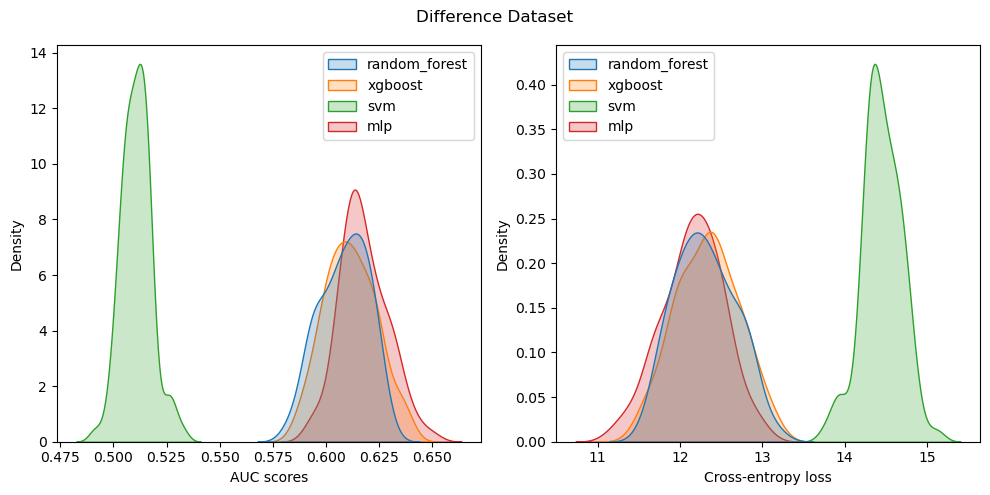

In [105]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Difference Dataset")
sns.kdeplot(df_auc, fill=True, ax=ax1)
sns.move_legend(ax1, "upper right")
ax1.set_xlabel('AUC scores')

sns.kdeplot(df_logl, fill=True, ax=ax2)
sns.move_legend(ax2, "upper left")
ax2.set_xlabel('Cross-entropy loss')

plt.tight_layout()

In [106]:
from scipy.stats import ttest_ind

all_pairs = [(a, b) for a in list(models.keys()) for b in set(models.keys()) - set([a])] # [(a, b) for idx, a in enumerate(list(models.keys())) for b in list(models.keys())[idx + 1:]]

auc_stats = {}
logl_stats = {}

for m1, m2 in all_pairs:
    t_val, p_val = ttest_ind(df_auc[m1], df_auc[m2], equal_var=False, alternative='greater')
    auc_stats[f"{m1} > {m2}"] = [t_val, p_val]

    t_val, p_val = ttest_ind(df_logl[m1], df_logl[m2], equal_var=False, alternative='greater')
    logl_stats[f"{m1} > {m2}"] = [t_val, p_val]

auc_stats = pd.DataFrame(auc_stats, index=['t_stat', 'p_val']).T
logl_stats = pd.DataFrame(logl_stats, index=['t_stat', 'p_val']).T

In [107]:
alpha = 0.05/12
auc_stats['reject H0?'] = auc_stats['p_val'] < alpha
logl_stats['reject H0?'] = logl_stats['p_val'] < alpha

display(auc_stats, logl_stats), f"Bonferonni correction alpha = {alpha}"

,t_stat,p_val,reject H0?
random_forest > mlp,-5.289250,9.999998e-01,False
random_forest > xgboost,-1.686392,9.532092e-01,False
random_forest > svm,67.105065,5.937459e-109,True
xgboost > random_forest,1.686392,4.679082e-02,False
xgboost > mlp,-3.448556,9.996434e-01,False
xgboost > svm,66.542877,4.995474e-106,True
svm > random_forest,-67.105065,1.000000e+00,False
svm > mlp,-74.079686,1.000000e+00,False
svm > xgboost,-66.542877,1.000000e+00,False
mlp > random_forest,5.289250,1.892792e-07,True


,t_stat,p_val,reject H0?
random_forest > mlp,2.627975,4.692687e-03,False
random_forest > xgboost,-0.465830,6.790294e-01,False
random_forest > svm,-45.379536,1.000000e+00,False
xgboost > random_forest,0.465830,3.209706e-01,False
xgboost > mlp,3.041535,1.365895e-03,True
xgboost > svm,-43.647532,1.000000e+00,False
svm > random_forest,45.379536,1.823244e-87,True
svm > mlp,47.933726,4.472462e-90,True
svm > xgboost,43.647532,5.098115e-84,True
mlp > random_forest,-2.627975,9.953073e-01,False


(None, 'Bonferonni correction alpha = 0.004166666666666667')

### 3.4. Evaluation plots

In [400]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=.2, stratify=df_y)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4812, 110), (1204, 110), (4812,), (1204,))

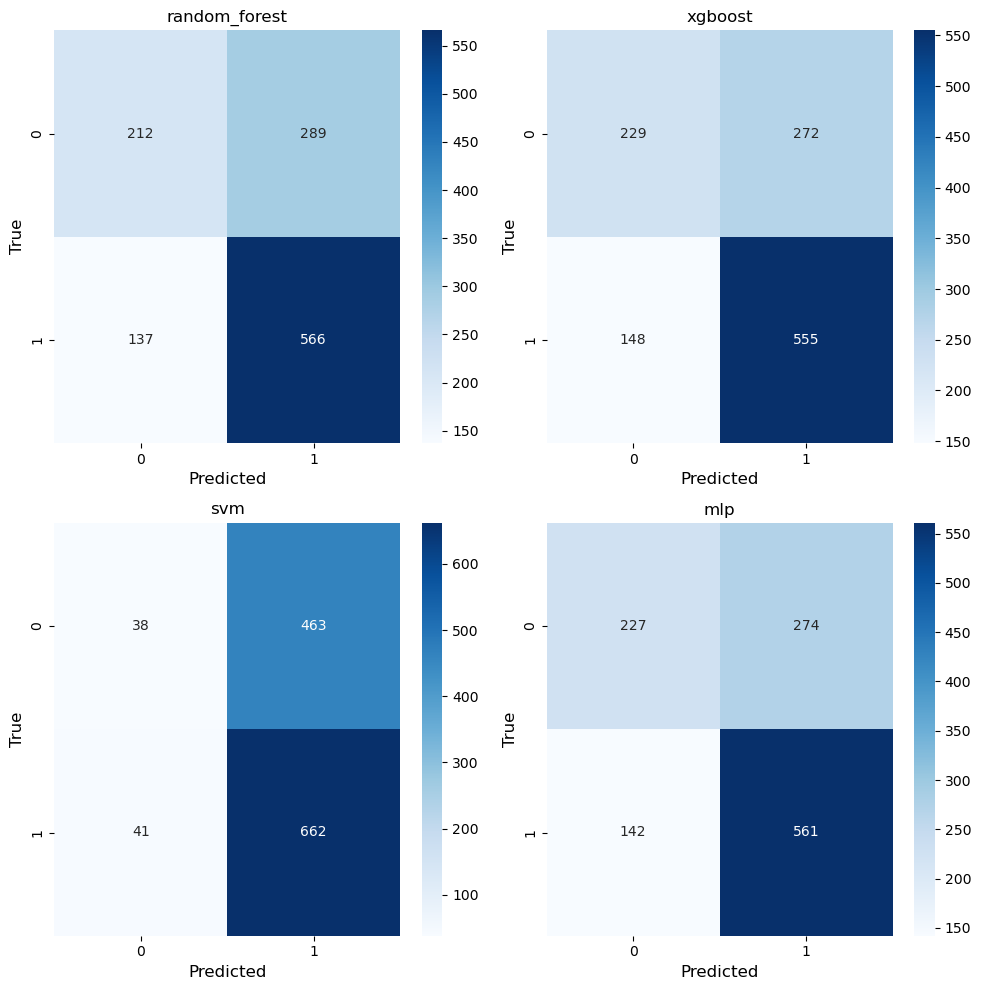

In [401]:
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for ax, (name, clf) in zip(axes, models.items()):

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', ax=ax)
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(f'{name}', fontsize=12)

plt.tight_layout()
plt.show()

### 3.5. Feature Importance

In [402]:
import shap

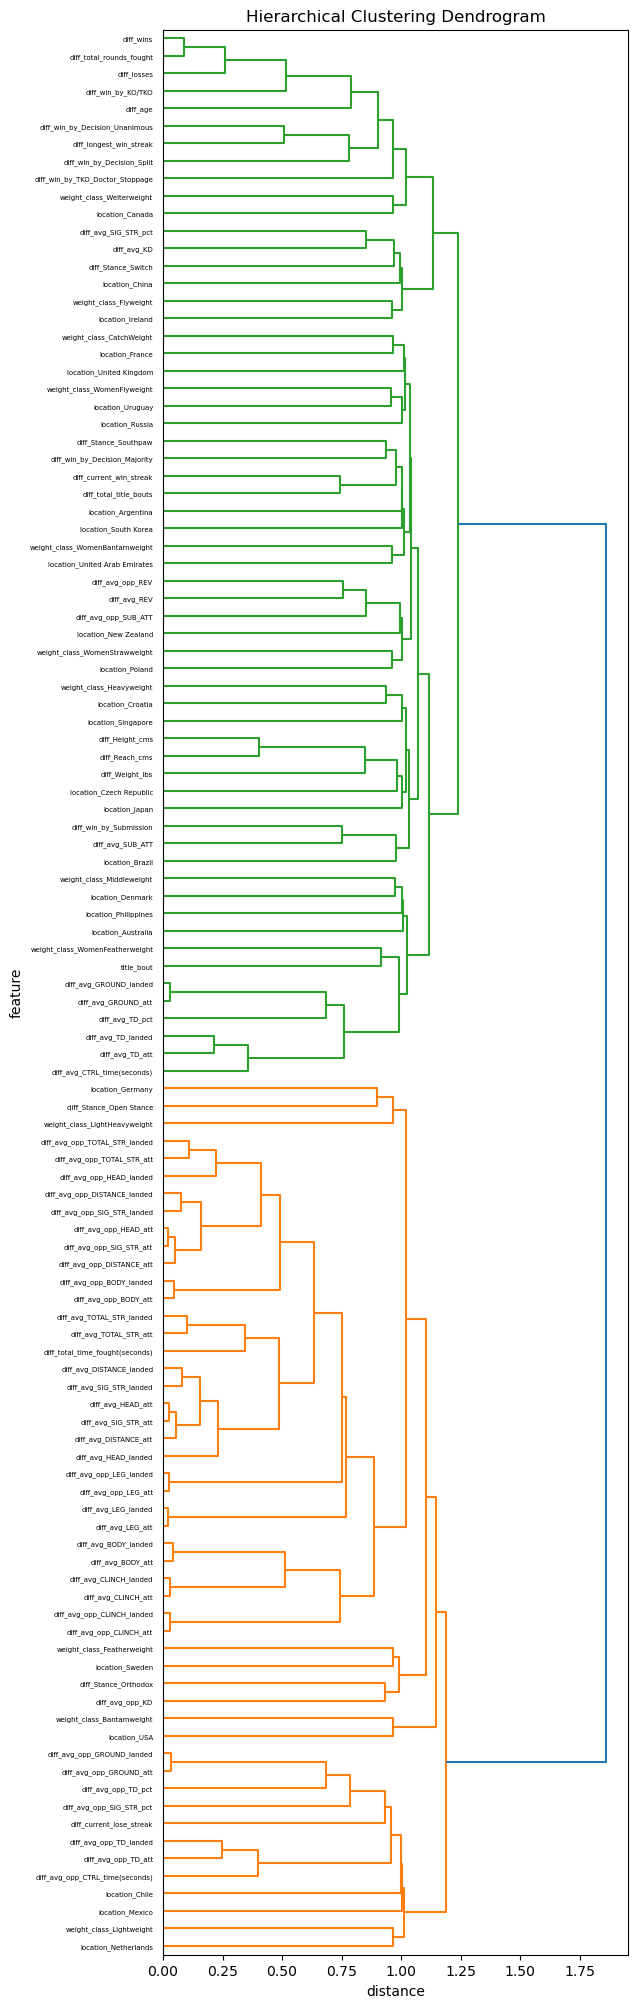

In [403]:
from scipy.cluster import hierarchy

partition_tree = shap.utils.partition_tree(X_train)
plt.figure(figsize=(6, 25))
hierarchy.dendrogram(partition_tree, labels=X_train.columns, orientation='right')

plt.title("Hierarchical Clustering Dendrogram")
plt.ylabel("feature")
plt.xlabel("distance")
plt.show()

In [405]:
shap.initjs()

# shap does not accept boolean features because these are seen as categorical
X_train['title_bout'] = X_train['title_bout']*1
X_test['title_bout'] = X_test['title_bout']*1

shap_values = {}

mlp_model = models['mlp']

explainer = shap.PermutationExplainer(mlp_model.predict_proba, X_train, feature_names=X_train.columns)
mlp_shap_values = explainer(X_test)[..., 1]

Permutation explainer: 1205it [06:17,  3.11it/s]                          


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


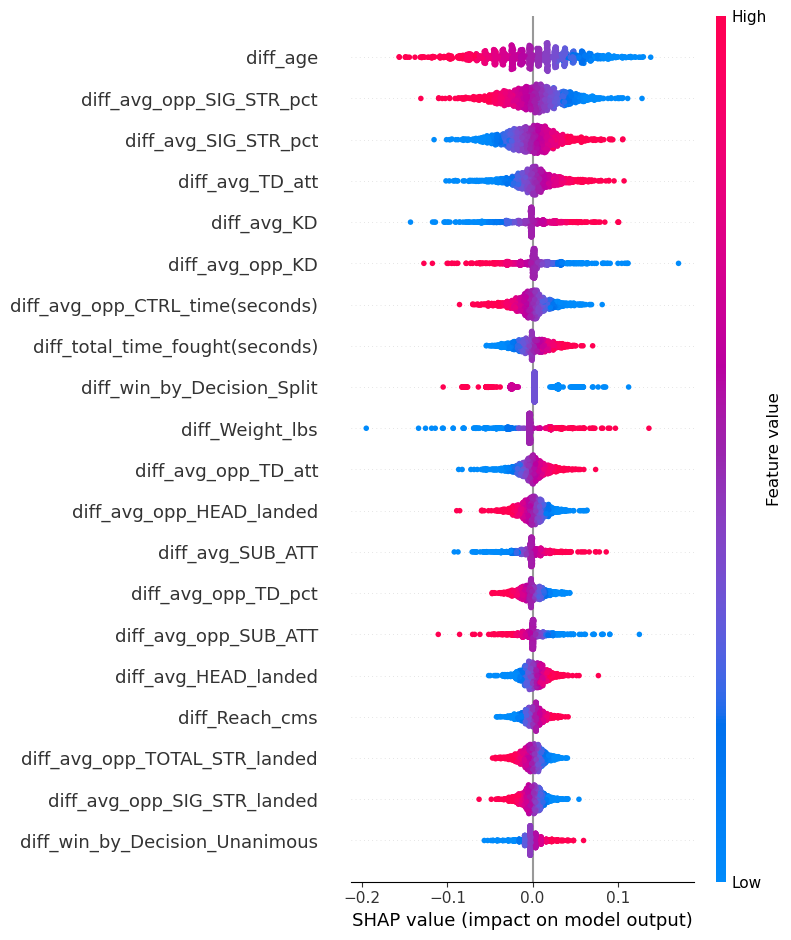

In [406]:
shap.summary_plot(mlp_shap_values)

## 4. Statistical test between datasets

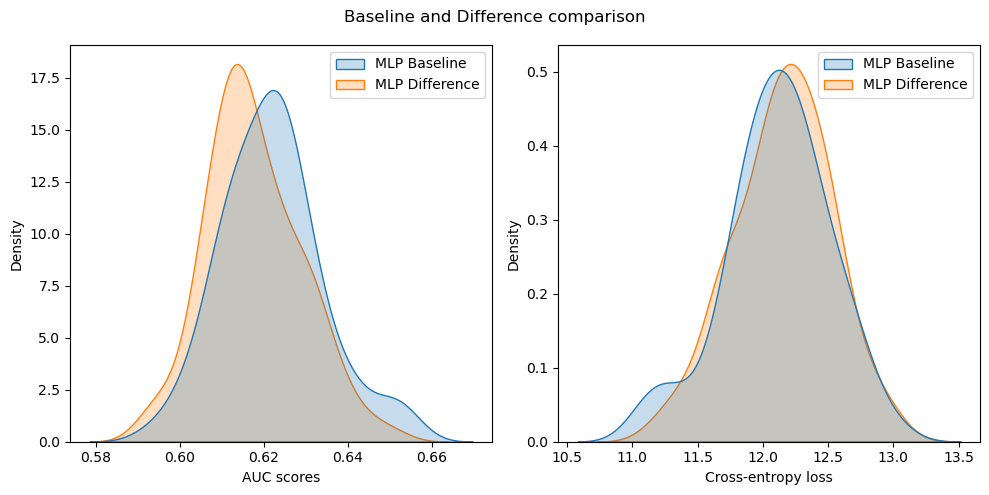

In [124]:
df_auc_diff = pd.read_csv('../score_samples/diff_auc.csv')
df_logl_diff = pd.read_csv('../score_samples/diff_logl.csv')

df_auc_base = pd.read_csv('../score_samples/baseline_auc.csv')
df_logl_base = pd.read_csv('../score_samples/baseline_logl.csv')

mlp_auc = pd.DataFrame({'MLP Baseline': df_auc_base['mlp'], 'MLP Difference': df_auc_diff['mlp']})
mlp_logl = pd.DataFrame({'MLP Baseline': df_logl_base['mlp'], 'MLP Difference': df_logl_diff['mlp']})

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

fig.suptitle("Baseline and Difference comparison")
sns.kdeplot(mlp_auc, fill=True, ax=ax1)
ax1.set_xlabel('AUC scores')

sns.kdeplot(mlp_logl, fill=True, ax=ax2)
ax2.set_xlabel('Cross-entropy loss')

plt.tight_layout()

In [136]:
ttest_ind(mlp_auc.iloc[:, 0], mlp_auc.iloc[:, 1], equal_var=False, alternative='greater')

Ttest_indResult(statistic=2.364455250442729, pvalue=0.009602006944565597)

In [130]:
ttest_ind(mlp_logl.iloc[:, 0], mlp_logl.iloc[:, 1], equal_var=False, alternative='greater')

Ttest_indResult(statistic=-0.7229126621288111, pvalue=0.7646280268359866)